# Итоговая работа по математике | ШАД МТС

### Выполнил: Рукавица Артём

## Введение

В данном исследовании проведён анализ датасета о стоимости поддержанных автомобилей в Индии (https://www.kaggle.com/datasets/avikasliwal/used-cars-price-prediction).

Цель работы заключалась в следующем:

1. Определить влияние различных характеристик (регион, год выпуска, пробег, тип топлива, тип трансмиссии, тип владельца, расход топлива, объём двигателя, мощность) на рыночную стоимость автомобиля.
2. Проверить статистически значимые различия между сегментами автомобилей, используя статистические критерии и тесты (например, тест Манна-Уитни, Левене), выдвинуть несколько гипотез.
3. Сформировать продуктовые гипотезы для сегментов, где показатели оказались ниже ожидаемых, и предложить идеи для проведения экспериментов, направленных на повышение рыночной стоимости поддержанных авто в отстающих группах (например, проведение опросов автомобилистов, увеличение срока гарантии производителем определенных моделей авто).
4. Построить базовую регрессионную модель, оценить ее качество на основе метрик (например, $R^2$, AIC/BIC, RMSE и MAE).
5. Улучшить спецификацию модели: провести тесты на наличие мультиколлинеарности и гетероскедастичности.
6. Сравнить две модели регрессии по различным метрикам и сделать выбор в пользу той или иной.

### 0. Загрузка библиотек, первичная обработка датасета

Загрузим необходимые библиотеки и наши данные.

In [ ]:
!pip install mplcyberpunk

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
import mplcyberpunk
from scipy.stats import gaussian_kde
import numpy as np
from scipy.stats import (mannwhitneyu, shapiro, levene, chi2_contingency,
                         kstest, normaltest, jarque_bera, skewtest, kurtosistest)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_white, het_goldfeldquandt
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
data = pd.read_csv('train-data.csv')
data.head(3)

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50


Исследуем данные на пропуски.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         6019 non-null   int64  
 1   Name               6019 non-null   object 
 2   Location           6019 non-null   object 
 3   Year               6019 non-null   int64  
 4   Kilometers_Driven  6019 non-null   int64  
 5   Fuel_Type          6019 non-null   object 
 6   Transmission       6019 non-null   object 
 7   Owner_Type         6019 non-null   object 
 8   Mileage            6017 non-null   object 
 9   Engine             5983 non-null   object 
 10  Power              5983 non-null   object 
 11  Seats              5977 non-null   float64
 12  New_Price          824 non-null    object 
 13  Price              6019 non-null   float64
dtypes: float64(2), int64(3), object(9)
memory usage: 658.5+ KB


Заметим, что в колонке `New_Price` всего 824 ячеек заполнены, остальные являются пропусками. Можем сбросить данную колонку. Отметим, что колонка `Unnamed: 0` является повторением индексов, поэтому также можем сбросить ее.

In [ ]:
data = data.drop(columns=['Unnamed: 0', 'New_Price'], axis=1)

Поработаем со столбцами `Mileage`, `Enigne` и `Power`. Заметим, что по смыслу они должны быть численными признаками, однако в них содержится информация в разных единицах измерения.

Для начала удалим строчки, в которых нет информации в этих столбцах. Их не так много, поэтому потерь данных не будет. Также заметим, что в признаке `Seats` все значения одинаковые (равны 5). Этот признак не является значимым, также можем его сбросить.

In [ ]:
data = data.dropna(subset=['Mileage', 'Engine', 'Power', 'Seats'])
data = data.reset_index(drop=True)

In [ ]:
# data['Name'].apply(lambda x: x.split()[0].).unique()

Переведем величину `Mileage` в единую единицу измерения, например, kmpl.

In [ ]:
data = data.copy()
mileage = []
for i in data['Mileage']:
    if isinstance(i, str):
        if i.endswith('km/kg'):
            i = float(i[:-6]) * 1.40
        elif i.endswith('kmpl'):
            i = float(i[:-6])
    else:
        i = None
    mileage.append(i)
data.loc[:, 'Mileage'] = mileage
data['Mileage'] = pd.to_numeric(data['Mileage'], errors='coerce')

Уберем единицы измерения в колонках `Power` и `Engine`.

In [ ]:
data = data.copy()
power = []
for i in data['Power']:
    number, bhp = i.split()
    if number != 'null':
        power.append(float(number))
    else:
        power.append(None)
data.loc[:, 'Power'] = power
data['Power'] = pd.to_numeric(data['Power'], errors='coerce')

In [ ]:
data = data.copy()
engine = []
for i in data['Engine']:
    number, cc = i.split()
    if number != 'null':
        engine.append(float(number))
    else:
        engine.append(None)
data.loc[:, 'Engine'] = engine
data['Engine'] = pd.to_numeric(data['Engine'], errors='coerce')

Удалим строчки с пропусками в колонках `Mileage`, `Engine`, `Power`. Более того, можем целиком удалить колонку `Seats`, поскольку она содержит единственное уникальное значение, равное 5.

In [ ]:
data = data.dropna(subset=['Mileage', 'Engine', 'Power'])
data = data.drop(['Seats'], axis=1)
data = data.reset_index(drop=True)

In [ ]:
data.head(3)

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,37.24,998.0,58.16,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.60,1582.0,126.20,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.00,1199.0,88.70,4.50


Все преобразования выполнены, датасет готов к анализу.

## 1. Блок "Теория вероятностей и математическая статистика"

1. Провести анализ датасета на предмет распределений признаков и составить общую картину различия/сходства распределений по факторам между группами. Можно ограничиться простыми плотностями и PSI / KS.
2. Сформулировать и протестировать несколько гипотез касательно разницы сегментов (к примеру, пользователей) по нескольким показателям. Сделать заключение о наличии или отсутствии статистически значимой разницы. К каждой оценке разницы между группами построить точечную и интервальную оценку. Интервальную можно построить методом бутстрэпа.
3. Если какая-то группа хуже другой, то сформировать ряд продуктовых гипотез, почему такое могло произойти и предложить идеи, какие эксперименты можно было провести на отстающей группе для повышения показателей.

### 1.1 Анализ датасета на основе распределений признаков, PSI, KS

#### 1.1.1 Графики распределения признаков

Начнем с распределения числовых признаков.

Для построения адекватных графиков и модели линейной регрессии я отброшу выбросы при помощи интерквартильного размаха.

In [ ]:
def remove_outliers(df, columns):
    df_filtered = df.copy()
    for col in columns:
        Q1 = df_filtered[col].quantile(0.25)
        Q3 = df_filtered[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_filtered = df_filtered[(df_filtered[col] >= lower_bound) & (df_filtered[col] <= upper_bound)]
    return df_filtered

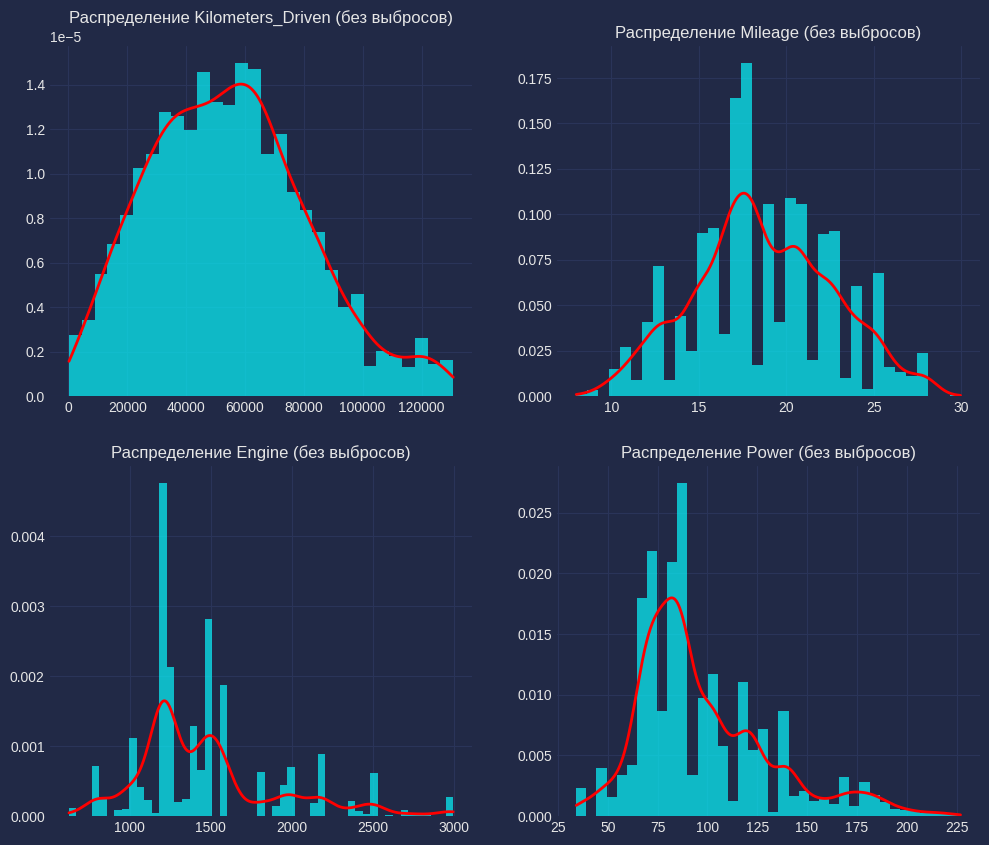

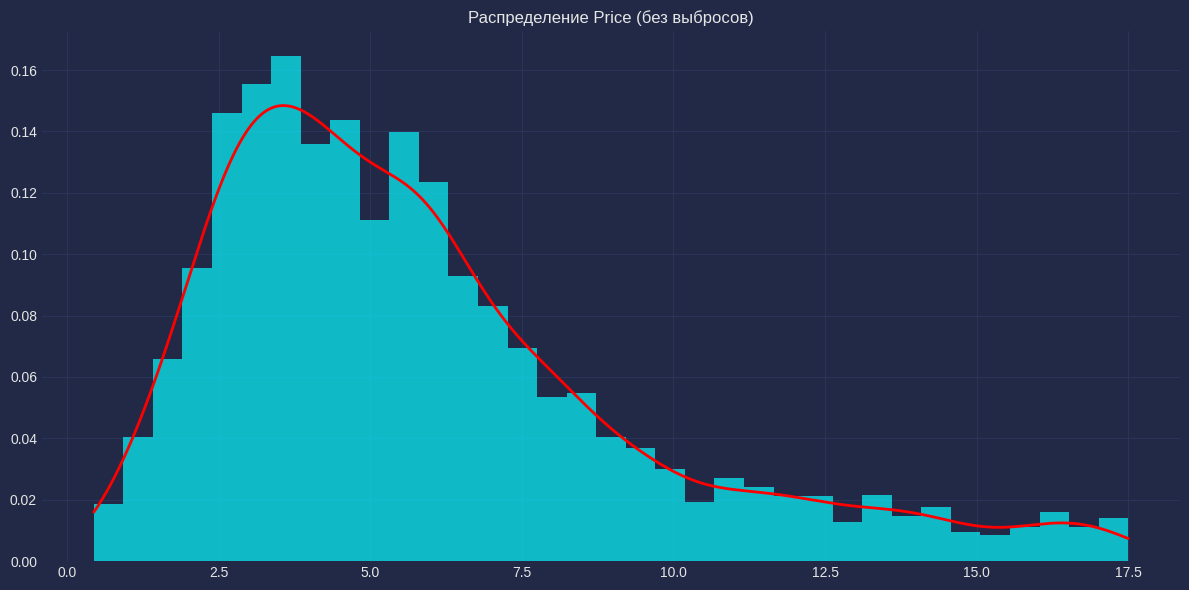

In [ ]:
numerical_features = ['Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Price']
data_filtered = remove_outliers(data, numerical_features)

with plt.style.context('cyberpunk'):
  fig, axes = plt.subplots(2, 2, figsize=(12, 10))
  fig_price, ax_price = plt.subplots(figsize=(12, 6))

  for ax, feature in zip(axes.flatten(), numerical_features[:-1]):
      ax.hist(data_filtered[feature], bins='auto', density=True, alpha=0.7)

      kde = gaussian_kde(data_filtered[feature])
      x = np.linspace(data_filtered[feature].min(), data_filtered[feature].max(), 1000)
      ax.plot(x, kde(x), color='red', linewidth=2, label='KDE')

      ax.set_title(f'Распределение {feature} (без выбросов)')
      ax.grid(True)


  ax_price.hist(data_filtered['Price'], bins='auto', density=True, alpha=0.7)
  kde = gaussian_kde(data_filtered['Price'])
  x = np.linspace(data_filtered['Price'].min(), data_filtered['Price'].max(), 1000)
  ax_price.plot(x, kde(x), color='red', linewidth=2, label='KDE')
  ax_price.set_title('Распределение Price (без выбросов)')
  ax_price.grid(True)

  plt.tight_layout()
  plt.show()

Небольшие выводы по каждому из графиков.
1. Kilometers_Driven.

Предиктор принимает различные значения от 0 до примерно 120000 км. Распределение имеет моду в районе 40–50 тысяч км, после чего постепенно «хвост» уходит вправо (в сторону больших значений пробега).
Судя по графику, типичная машина из выборки проезжает 40–60 тысяч км до момента продажи.
2. Mileage


Принимает значения примерно от 10 до 30 км/л (эта единица измерения весьма популярна в Индии). Данные весьма разреженные (есть резкие скачки и падения), мода находится на 17-18 условных единицах.

3. Engine

Принимает значения от ~600–800 см^3 до ~3000 см^3. Данные разреженные (например, есть широкий пропуск между 1500 и 2000 у.е.). Есть разделение по кластерам: 800–1000 см^3 (малолитражки), 1200–1500 см^3 (типичные бюджетные авто), 2000+ см^3 (мощные автомобили). Характерное разделение по кластерам наводит на мысль, что в датасете представлен широкий спектр автомобилей разных классов.

4. Power

В целом, есть разделение на кластеры, свойственное распределению Engine: малым автомобилям соотвествует малая мощность (в лошадиных силах).

5. Price

Таргет распределен в пределах от 0 до 17–18 (в лаках, т.е. десятках тысяч, индийских рупий). Мода находится около значений 3–4, затем плавное снижение плотности к «хвосту» справа. Таким образом, в выборке преобладают относительно недорогие автомобили (основная часть в районе 3–5 единиц), но присутствует «длинный хвост» из более дорогих моделей.

Теперь выведем графики для категориальных признаков, предварительно отсортировав гистограммы.

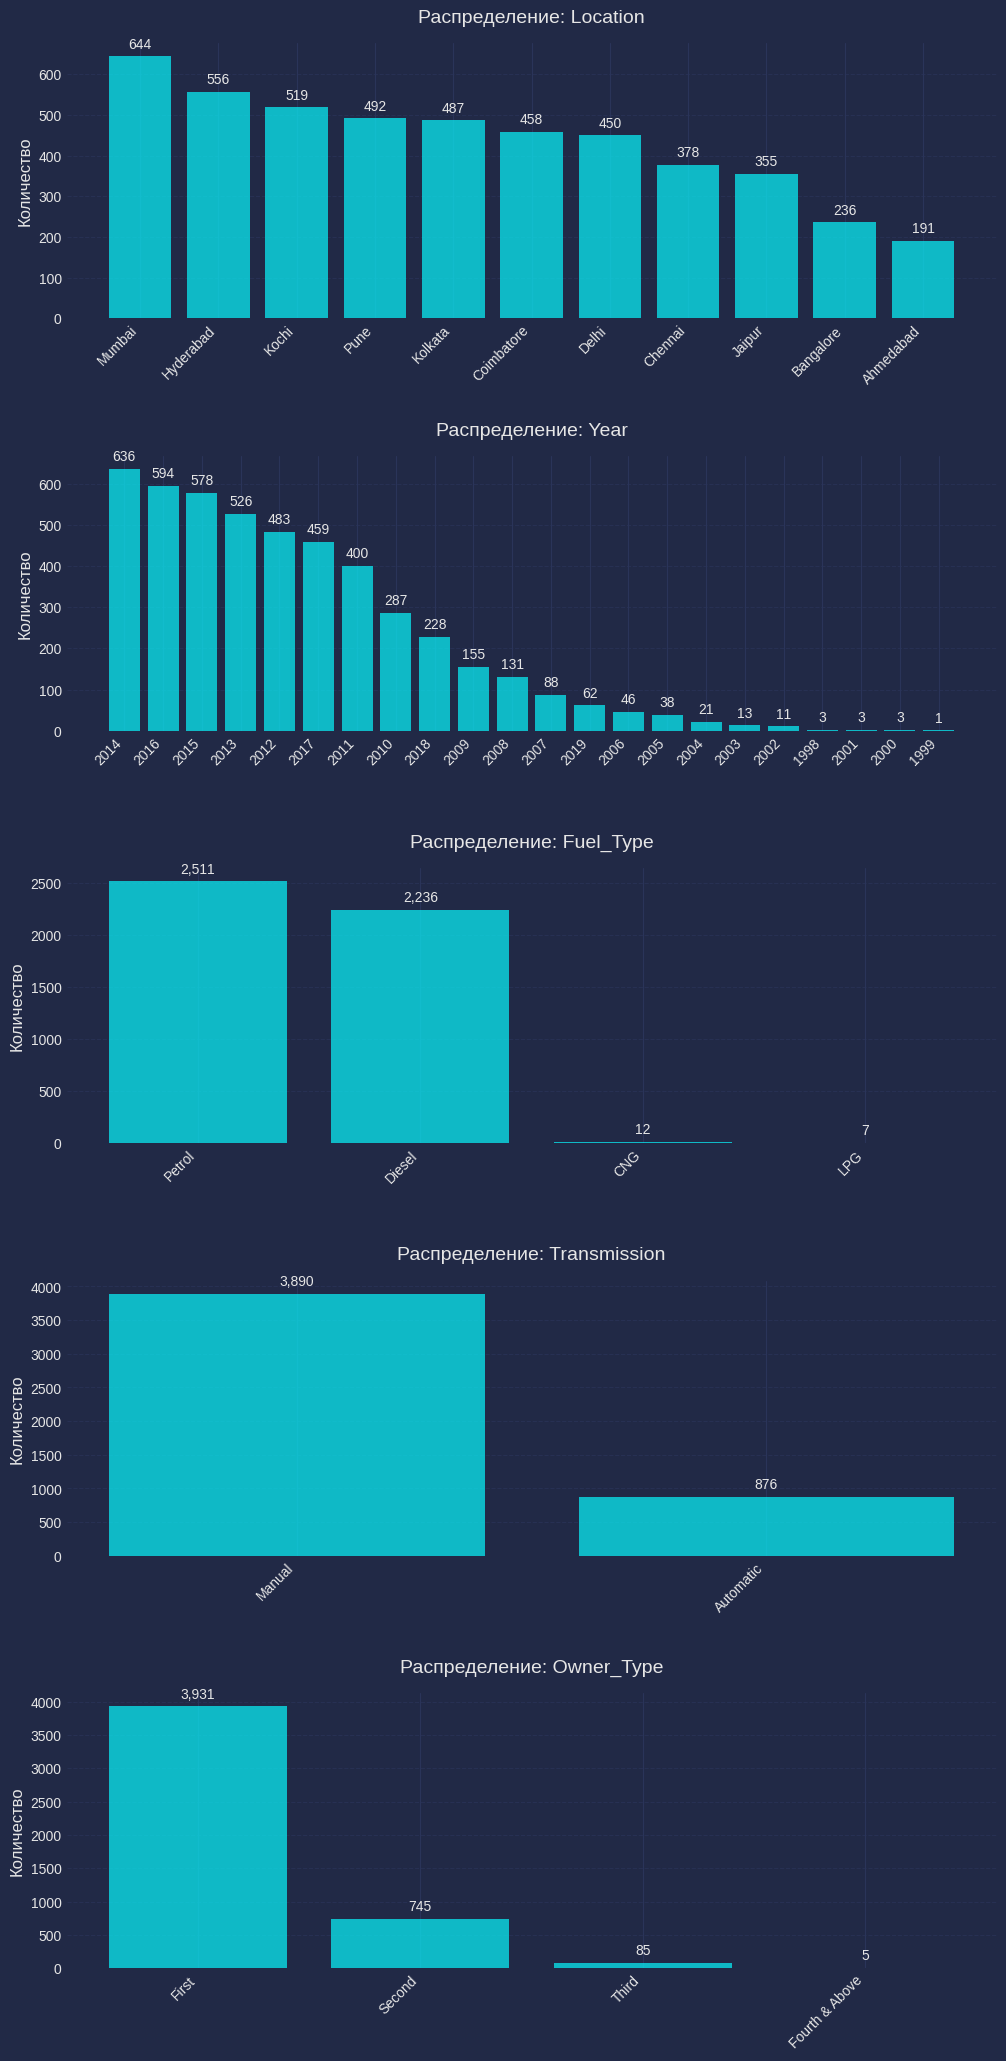

In [ ]:
categorical_features = ['Location', 'Year', 'Fuel_Type', 'Transmission', 'Owner_Type']

with plt.style.context('cyberpunk'):
  fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 25))
  plt.subplots_adjust(hspace=0.5)

  for idx, (feature, ax) in enumerate(zip(categorical_features, axes)):
      unique, counts = np.unique(data_filtered[feature], return_counts=True)

      sorted_idx = np.argsort(-counts)
      unique = unique[sorted_idx]
      counts = counts[sorted_idx]

      bars = ax.bar(
          x=range(len(unique)),
          height=counts,
          alpha=0.7
      )

      ax.set_title(f'Распределение: {feature}', fontsize=14, pad=15)
      ax.set_xticks(range(len(unique)))
      ax.set_xticklabels(unique, rotation=45, ha='right', fontsize=10)
      ax.set_ylabel('Количество', fontsize=12)
      ax.grid(axis='y', linestyle='--', alpha=0.7)

      for bar in bars:
          height = bar.get_height()
          ax.text(
              x=bar.get_x() + bar.get_width()/2,
              y=height + 0.02 * max(counts),
              s=f'{height:,}',
              ha='center',
              va='bottom',
              fontsize=10
          )

  plt.show()

Немного выводов по гистограммам.

1. Location

Всего в выборке представлено 11 индийских городов, отличие между наиболее встречающимся (Мумбаи) и наименее встречающимся (Ахмедабад) примерно в 3.5 раз.

2. Year

Пик предложений приходится на автомобили примерно середины 2010-х годов, автомобили более ранних годов встречаются очень редко.

3. Fuel_Type

Доминирующее положение занимают машины с топливом Petrol (бензин) и Diesel (дизель), они находятся в датасете примерно в равных пропорциях. Совсем редко встречаются авто с топливом CNG и LPG.

4. Transmission

Всего встречаются авто с двумя типами трансмиссии: ручной и автоматической; подавляющее большинство продаваемых автомобилей Manual, и лишь небольшая часть Automatic.

5. Owner_Type

Основная масса объявлений — машины, которые продает первый владелец (First Owner). Автомобилей, проданных через третьи руки и более, существенно меньше.

#### 1.1.2 Графики распределений по факторам (группам)

Построим график распределения цены по типу топлива.

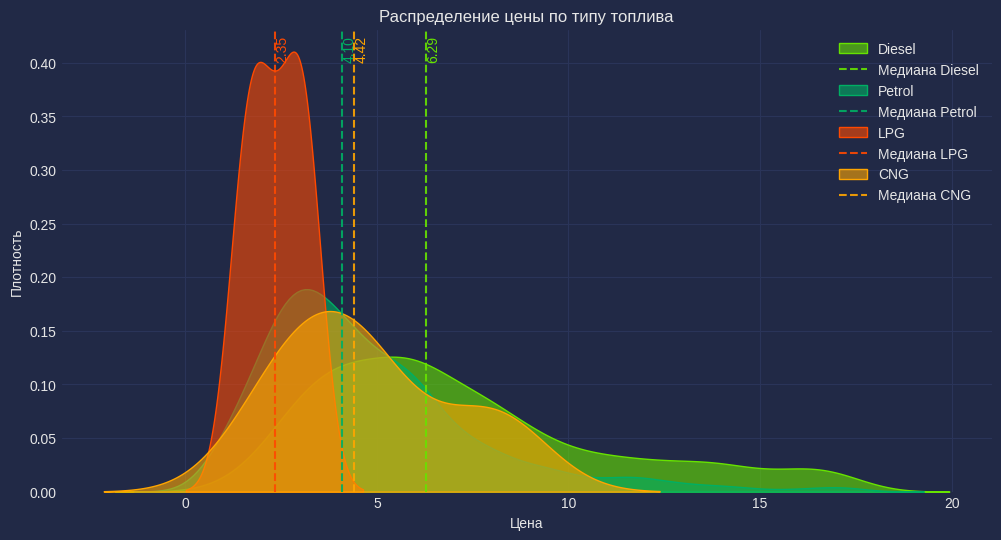

In [ ]:
with plt.style.context('cyberpunk'):
  plt.figure(figsize=(12, 6))
  #colors = sns.color_palette("Set1", len(data['Fuel_Type'].unique()))
  #colors = ['white', 'yellow', 'red', 'orange']
  colors = ['#67E300', '#00AF64', '#FF4900', 'orange']
  for fuel, color in zip(data_filtered['Fuel_Type'].unique(), colors):
      subset = data_filtered[data_filtered['Fuel_Type'] == fuel]
      sns.kdeplot(subset['Price'], label=fuel, fill=True, color=color, alpha=0.6)

      median_price = subset['Price'].median()
      plt.axvline(median_price, linestyle='--', alpha=0.9, color=color, label=f'Медиана {fuel}')
      plt.text(median_price, 0.4, f'{median_price:.2f}',
              rotation=90, verticalalignment='bottom', fontsize=10, color=color)

  plt.title('Распределение цены по типу топлива')
  plt.legend()
  plt.xlabel('Цена')
  plt.ylabel('Плотность')
  plt.grid(True)
  plt.show()

Можем заметить, что автомобили с дизелем и бензином (соответственно Diesel и Petrol) распределены по всевозможным ценам в датасета, чего нельзя сказать об автомобилях с сжиженным углеводородным газам и с сжатым природным газом (соответственно LPG и CNG): цена LPG сконцетрирована в пределах от 0 до 5 с медианой 2.35 условных единиц, а цена CNG распределена чуть шире, до 12.5 условных единиц с двумя модами: около 4 и около 8 у.е.

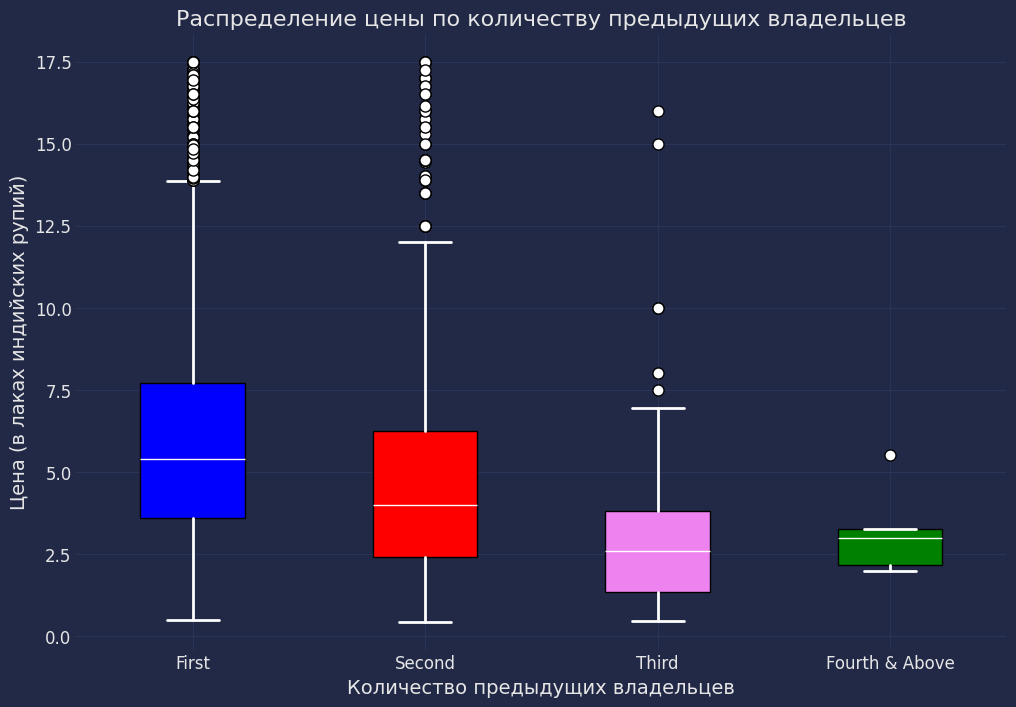

In [ ]:
with plt.style.context('cyberpunk'):
  owners = data_filtered['Owner_Type'].unique()
  data = [data_filtered[data_filtered['Owner_Type'] == owner]['Price'] for owner in owners]
  plt.figure(figsize=(12, 8))
  flierprops = dict(marker='o', markerfacecolor='white', markersize=8,
                    linestyle='none', markeredgecolor='black')
  medianprops = dict(color='white', linewidth=1)

  box = plt.boxplot(data, patch_artist=True, flierprops=flierprops, medianprops=medianprops)

  for whisker in box['whiskers']:
    whisker.set_color('white')
    whisker.set_linewidth(2)

  for cap in box['caps']:
    cap.set_color('white')
    cap.set_linewidth(2)

  colors = ['blue', 'C4', 'violet', 'green']
  for patch, color in zip(box['boxes'], colors):
      patch.set_facecolor(color)

  plt.xlabel('Количество предыдущих владельцев', fontsize=14)
  plt.ylabel('Цена (в лаках индийских рупий)', fontsize=14)
  plt.title('Распределение цены по количеству предыдущих владельцев', fontsize=16)
  plt.xticks(ticks=range(1, len(owners) + 1), labels=owners, fontsize=12)
  plt.yticks(fontsize=12)
  plt.grid(True)

Boxplot распределения цены по количеству предыдущих владельцев дал весьма логичную картинку: чем больше владельцев у авто было, тем ниже средняя цена, поскольку большое количество владельцев может означать высокую степень износа машины. Однако важно отметить, что в первых двух категориях есть большое количество выбросов, которое может соответствовать более качественным машинам.

#### 1.1.3 PSI

Исследуем, изменились ли распределения во времени у числовых признаков. Разделим данные на две группы: до 2014 года включительно и после него.

In [ ]:
import numpy as np
import pandas as pd

def calculate_psi(expected, actual, n_bins=10, eps=1e-8):
    expected = pd.Series(expected).dropna()
    actual = pd.Series(actual).dropna()

    min_val = min(expected.min(), actual.min())
    max_val = max(expected.max(), actual.max())
    bins = np.linspace(min_val, max_val, n_bins+1)

    expected_perc = np.histogram(expected, bins=bins)[0] / len(expected)
    actual_perc = np.histogram(actual, bins=bins)[0] / len(actual)
    expected_perc = np.clip(expected_perc, eps, None)
    actual_perc = np.clip(actual_perc, eps, None)

    return np.sum((expected_perc - actual_perc) * np.log(expected_perc / actual_perc))


expected_df = data_filtered[data_filtered["Year"] < 2015]
actual_df   = data_filtered[data_filtered["Year"] >= 2015]
numeric_columns = ["Kilometers_Driven", "Mileage", "Engine", "Power", "Price"]
psi_results = {}
for col in numeric_columns:
    psi_val = calculate_psi(
        expected=expected_df[col],
        actual=actual_df[col],
        n_bins=10
    )
    psi_results[col] = psi_val

print("PSI по каждому числовому признаку:")
for col, val in psi_results.items():
    print(f"{col}: {val:.4f}")

PSI по каждому числовому признаку:
Kilometers_Driven: 1.0478
Mileage: 0.4889
Engine: 0.2865
Power: 0.3579
Price: 1.0077


PSI по каждому из признаков больше 0.2 (т.е. есть значимые изменения в распределениях). Оно и логично: автопром не стоит на месте (появляются более экономичные варианты авто, более мощные, более экологичные), пробег более молодых авто гораздо меньше, чем пробег более старых, а стоимость молодых авто гораздо выше, чем стоимость более старых (в силу меньшего износа).

#### 1.1.4 KS-тест (тест Колмогорова-Смирнова)

Проведем тест Колмогорова-Смирнова, проверяющий гипотезу о равенстве распределений между группами, например, для распределения цены по типу топлива. Сравним попарные распределения для фильтрованных данных (то есть без выбросов).

In [ ]:
fuel_type = data_filtered['Fuel_Type'].unique()

for i in range(len(fuel_type)):
    for j in range(i + 1, len(fuel_type)):
        type1, type2 = fuel_type[i], fuel_type[j]
        print(f"Гипотеза о равенстве распределений цены по типу топлива {type1} и {type2}")

        group1 = data_filtered[data_filtered['Fuel_Type'] == type1]['Price']
        group2 = data_filtered[data_filtered['Fuel_Type'] == type2]['Price']

        ks_stat, p_value = ks_2samp(group1, group2)
        print("KS-статистика:", ks_stat)
        print("p-value:", p_value)
        print()

Гипотеза о равенстве распределений цены по типу топлива Diesel и Petrol
KS-статистика: 0.3084143543008259
p-value: 7.373261450431869e-100

Гипотеза о равенстве распределений цены по типу топлива Diesel и LPG
KS-статистика: 0.8908765652951699
p-value: 4.077162131842923e-07

Гипотеза о равенстве распределений цены по типу топлива Diesel и CNG
KS-статистика: 0.3810375670840787
p-value: 0.04565259728422359

Гипотеза о равенстве распределений цены по типу топлива Petrol и LPG
KS-статистика: 0.6690561529271206
p-value: 0.0013220400410902913

Гипотеза о равенстве распределений цены по типу топлива Petrol и CNG
KS-статистика: 0.12216248506571087
p-value: 0.9845057669350623

Гипотеза о равенстве распределений цены по типу топлива LPG и CNG
KS-статистика: 0.75
p-value: 0.0072636341986187175



Для всевозможных пар значение p-value меньше 0.05, поэтому распределения статистически различаются.

Введем новую фичу: разделим локации по регионам страны.

* Северная/Восточная Индия: Delhi, Jaipur, Kolkata

* Западная Индия: Mumbai, Pune, Ahmedabad

* Южная Индия: Chennai, Hyderabad, Bangalore, Coimbatore, Kochi

In [ ]:
def make_regions(city):
  if city in ['Delhi', 'Jaipur', 'Kolkata']:
    return 'north-east'
  if city in ['Mumbai', 'Pune', 'Ahmedabad']:
    return 'west'
  return 'south'

data_filtered['Region'] = data_filtered['Location'].apply(make_regions)

Проведем тест Колмогорова-Смирнова, проверяющий гипотезу о равенстве распределений цены автомобиля по регионам выставления объявления о продаже.

In [ ]:
regions = data_filtered['Region'].unique()

for i in range(len(regions)):
    for j in range(i + 1, len(regions)):
        type1, type2 = regions[i], regions[j]
        print(f"Гипотеза о равенстве распределений цены по типу топлива {type1} и {type2}")

        group1 = data_filtered[data_filtered['Region'] == type1]['Price']
        group2 = data_filtered[data_filtered['Region'] == type2]['Price']

        ks_stat, p_value = ks_2samp(group1, group2)
        print("KS-статистика:", ks_stat)
        print("p-value:", p_value)
        print()

Гипотеза о равенстве распределений цены по типу топлива west и south
KS-статистика: 0.11459252127624849
p-value: 7.699263479294594e-10

Гипотеза о равенстве распределений цены по типу топлива west и north-east
KS-статистика: 0.10266645824632951
p-value: 1.8093492340091692e-06

Гипотеза о равенстве распределений цены по типу топлива south и north-east
KS-статистика: 0.21443053234335188
p-value: 5.7651058035534535e-33



Для всевозможных пар значение p-value меньше 0.05, поэтому распределения статистически различаются.

### 1.2 Формулировка и проверка гипотез

Для многих популярных тестов требуется нормальность данных. Проверим ее при помощи теста Шапиро-Уилка.

In [ ]:
numerical_features = ['Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Price']
for feature in numerical_features:
    print(f"{feature}\t: {shapiro(data_filtered[feature])}")

Kilometers_Driven	: ShapiroResult(statistic=np.float64(0.9846155147738256), pvalue=np.float64(2.211623756809386e-22))
Mileage	: ShapiroResult(statistic=np.float64(0.9914579069368905), pvalue=np.float64(2.3431915102054377e-16))
Engine	: ShapiroResult(statistic=np.float64(0.8942718757452929), pvalue=np.float64(2.7480902008971833e-49))
Power	: ShapiroResult(statistic=np.float64(0.9169344942956262), pvalue=np.float64(2.5654295914704846e-45))
Price	: ShapiroResult(statistic=np.float64(0.9009175530720425), pvalue=np.float64(3.3449067938470733e-48))


К сожалению, нет численных признаков, которые являются нормальными. Придумаем, как провести статистический анализ другими тестами.

#### 1.2.1 Тест Манна-Уитни

Сформулируем гипотезу: медианные значения цен на машины с дизелем и бензином совпадают.

In [ ]:
diesel_prices = data_filtered[data_filtered['Fuel_Type'] == 'Diesel']['Price'].dropna()
petrol_prices = data_filtered[data_filtered['Fuel_Type'] == 'Petrol']['Price'].dropna()

mannwhitneyu(diesel_prices, petrol_prices, alternative='two-sided')

MannwhitneyuResult(statistic=np.float64(3993524.5), pvalue=np.float64(8.920638732643903e-140))

Получили p-value < 0.05, то есть не принимаем гипотезу, есть статистические различия.

Построим точечную оценку для разности медиан между группами на основе оценки Ходжеса-Лемана.

In [ ]:
def hodges_lehmann_estimator(group1, group2):
    differences = []
    for x in group1:
        for y in group2:
            differences.append(x - y)
    return np.median(differences)

hl_estimate = hodges_lehmann_estimator(diesel_prices.values, petrol_prices.values)
print(f"Оценка Ходжеса–Лемана (точечная оценка разницы): {hl_estimate:.3f}")

Оценка Ходжеса–Лемана (точечная оценка разницы): 2.110


Построим доверительный интервал при помощи бутстрепа.

In [ ]:
def bootstrap_diff(data1, data2, n_bootstrap=5000, ci=95):
    diffs = []
    n1, n2 = len(data1), len(data2)
    for _ in range(n_bootstrap):
        sample1 = np.random.choice(data1, size=n1, replace=True)
        sample2 = np.random.choice(data2, size=n2, replace=True)
        diffs.append(np.median(sample1) - np.median(sample2))
    lower = np.percentile(diffs, (100 - ci) / 2)
    upper = np.percentile(diffs, 100 - (100 - ci) / 2)
    return np.array(diffs), lower, upper

boot_diffs, lower_ci, upper_ci = bootstrap_diff(diesel_prices.values, petrol_prices.values, n_bootstrap=5000, ci=95)
print(f"Bootstrap 95% доверительный интервал для разницы медиан цены: ({lower_ci:.3f}, {upper_ci:.3f})")

Bootstrap 95% доверительный интервал для разницы медиан цены: (1.960, 2.500)


Точечная оценка лежит внутри 95% доверительного интервала.

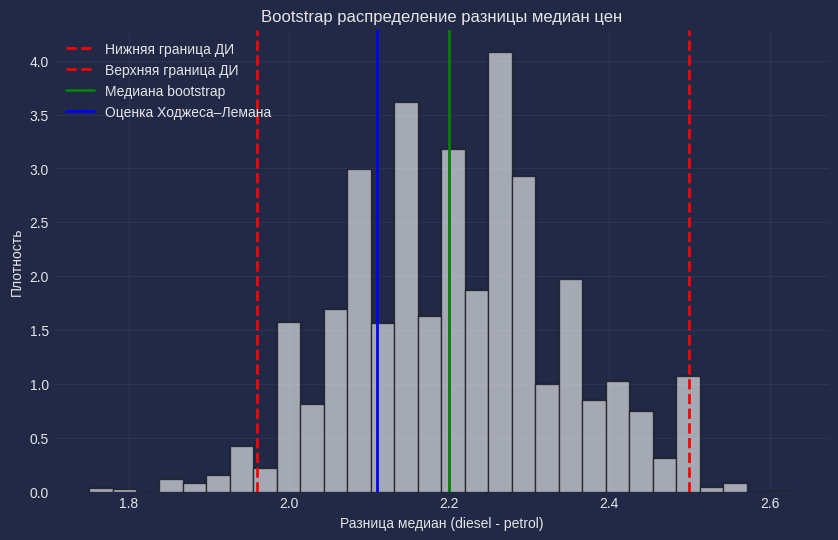

In [ ]:
with plt.style.context('cyberpunk'):
  plt.figure(figsize=(10, 6))
  plt.hist(boot_diffs, bins=30, density=True, alpha=0.6, color='white', edgecolor='black')
  plt.title('Bootstrap распределение разницы медиан цен')
  plt.xlabel('Разница медиан (diesel - petrol)')
  plt.ylabel('Плотность')

  plt.axvline(lower_ci, color='red', linestyle='--', linewidth=2, label='Нижняя граница ДИ')
  plt.axvline(upper_ci, color='red', linestyle='--', linewidth=2, label='Верхняя граница ДИ')
  median_boot = np.median(boot_diffs)
  plt.axvline(median_boot, color='green', linestyle='-', linewidth=2, label='Медиана bootstrap')
  plt.axvline(hl_estimate, color='blue', linestyle='-', linewidth=2, label='Оценка Ходжеса–Лемана')

  plt.legend(facecolor='white', loc='upper left')
  plt.show()

Разница медиан (diesel - petrol) лежит значительно выше нуля, то есть цена на авто на дизельном топливе выше цены на бензине. ДИ, полученный при помощи бутстрепа, не пересекает ноль, значит разница в медианных ценах статистически значима (что мы также получили при помощи теста Манна-Уитни). Точечная оценка (Ходжеса–Лемана) и медиана бутстреп-распределения принимают довольно близкие значения (отклонение составляет примерно 0.1), что показывает устойчивую разницу. Сам ДИ довольно узкий, его ширина составляет около 0.5 условных единиц, что указывает на небольшую неопределённость оценки.

Таким образом, медианная цена автомобилей на дизеле стабильно (и статистически значимо) превышает медианную цену авто на бензине на величину около 2.1 условных единиц.

Сформулируем еще одну гипотезу: медианная мощность (Power) автомобилей с ручной коробкой передач равна медианной мощности автомобилей с автоматической коробкой.

In [ ]:
auto_power = data_filtered[data_filtered['Transmission'] == 'Automatic']['Power'].dropna()
manual_power = data_filtered[data_filtered['Transmission'] == 'Manual']['Power'].dropna()

mannwhitneyu(auto_power, manual_power, alternative='two-sided')

MannwhitneyuResult(statistic=np.float64(2682725.5), pvalue=np.float64(5.20094522828405e-156))

Получили p-value < 0.05, то есть не принимаем гипотезу, есть статистические различия.

Аналогично первой гипотезе построим точечную оценку для разности медиан.

In [ ]:
hl_estimate = hodges_lehmann_estimator(auto_power.values, manual_power.values)
print(f"Оценка Ходжеса–Лемана (точечная оценка разницы): {hl_estimate:.3f}")

Оценка Ходжеса–Лемана (точечная оценка разницы): 41.400


Аналогично первой гипоетезе построим интервальную оценку на основе бутстрепа.

In [ ]:
boot_diffs, lower_ci, upper_ci = bootstrap_diff(auto_power.values, manual_power.values, n_bootstrap=5000, ci=95)
print(f"Bootstrap 95% доверительный интервал для разницы медиан расхода: ({lower_ci:.2f}, {upper_ci:.2f})")

Bootstrap 95% доверительный интервал для разницы медиан расхода: (39.50, 52.23)


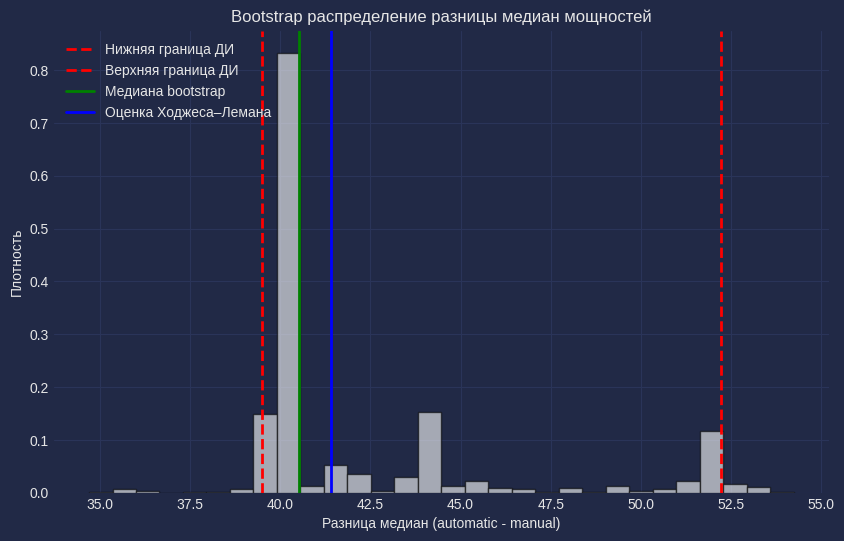

In [ ]:
with plt.style.context('cyberpunk'):
  plt.figure(figsize=(10, 6))
  plt.hist(boot_diffs, bins=30, density=True, alpha=0.6, color='white', edgecolor='black')
  plt.title('Bootstrap распределение разницы медиан мощностей')
  plt.xlabel('Разница медиан (automatic - manual)')
  plt.ylabel('Плотность')

  plt.axvline(lower_ci, color='red', linestyle='--', linewidth=2, label='Нижняя граница ДИ')
  plt.axvline(upper_ci, color='red', linestyle='--', linewidth=2, label='Верхняя граница ДИ')
  median_boot = np.median(boot_diffs)
  plt.axvline(median_boot, color='green', linestyle='-', linewidth=2, label='Медиана bootstrap')
  plt.axvline(hl_estimate, color='blue', linestyle='-', linewidth=2, label='Оценка Ходжеса–Лемана')

  plt.legend(facecolor='white', loc='upper left')
  plt.show()

Разница медиан (automatic - manual) лежит значительно выше нуля, то есть мощность авто с автоматической трансмиссией выше мощности авто с ручной. ДИ, полученный при помощи бутстрепа, не пересекает ноль, значит разница в медианных ценах статистически значима (что мы также получили при помощи теста Манна-Уитни). Точечная оценка (Ходжеса–Лемана) и медиана бутстреп-распределения принимают довольно близкие значения (отклонение составляет примерно 1), что показывает устойчивую разницу медиан. Сам ДИ весьма широкий, разница медиан колеблется в достаточно широких пределах, но при этом весь интервал остаётся положительным. В данной гистограмме есть несколько «горбов», которые, вероятно, появились из-за наличия нескольких кластеров автомобилей (менее мощные, обычные и более мощные, см. рассуждения выше), но все они показывают положительную разницу.

Таким образом, авто с автоматической трансмиссией стабильно мощнее авто с механической трансмиссией.

#### 1.2.2 Тест Левене

Сформулируем нулевую гипотезу: дисперсии распределений цен по регионам страны совпадают.

In [ ]:
north_east_prices = data_filtered[data_filtered['Region'] == 'north-east']['Price'].dropna()
west_prices = data_filtered[data_filtered['Region'] == 'west']['Price'].dropna()
south_prices = data_filtered[data_filtered['Region'] == 'south']['Price'].dropna()

levene(north_east_prices, west_prices, south_prices)

LeveneResult(statistic=np.float64(6.170736830337309), pvalue=np.float64(0.002106439761161014))

Исходя из результатов (p-value < 0.05) есть основания не принимать гипотезу о равенстве дисперсий. Продемонстрируем это на boxplot.

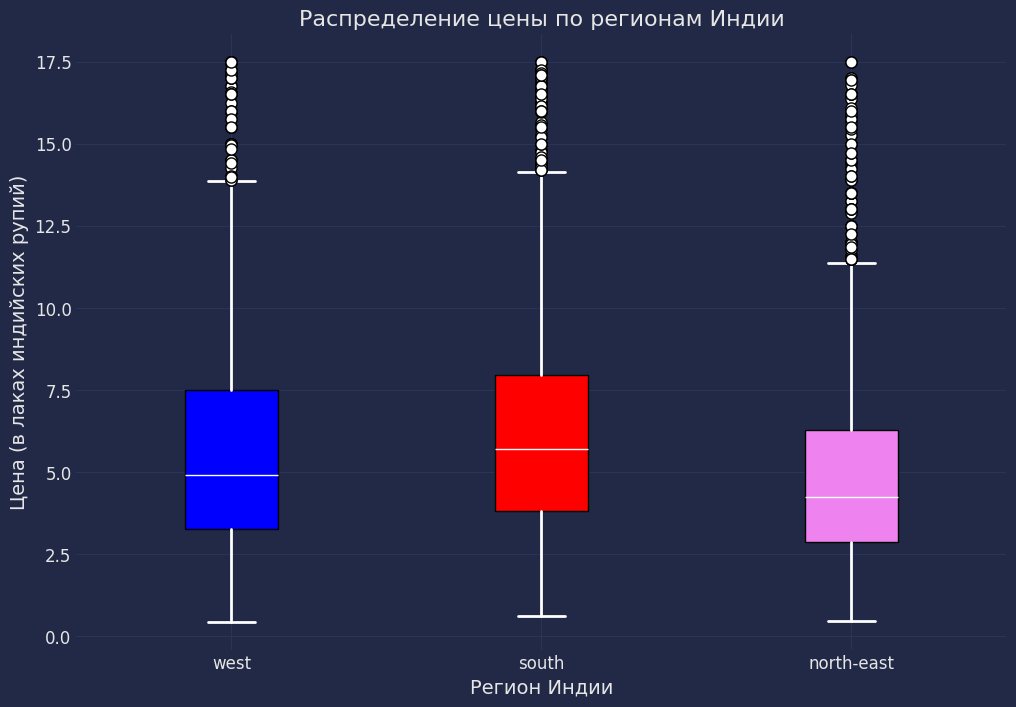

In [ ]:
with plt.style.context('cyberpunk'):
  regions = data_filtered['Region'].unique()
  data = [data_filtered[data_filtered['Region'] == region]['Price'] for region in regions]
  plt.figure(figsize=(12, 8))
  flierprops = dict(marker='o', markerfacecolor='white', markersize=8,
                    linestyle='none', markeredgecolor='black')
  medianprops = dict(color='white', linewidth=1)

  box = plt.boxplot(data, patch_artist=True, flierprops=flierprops, medianprops=medianprops)

  for whisker in box['whiskers']:
    whisker.set_color('white')
    whisker.set_linewidth(2)

  for cap in box['caps']:
    cap.set_color('white')
    cap.set_linewidth(2)

  colors = ['blue', 'C4', 'violet', 'green']
  for patch, color in zip(box['boxes'], colors):
      patch.set_facecolor(color)

  plt.xlabel('Регион Индии', fontsize=14)
  plt.ylabel('Цена (в лаках индийских рупий)', fontsize=14)
  plt.title('Распределение цены по регионам Индии', fontsize=16)
  plt.xticks(ticks=range(1, len(regions) + 1), labels=regions, fontsize=12)
  plt.yticks(fontsize=12)
  plt.grid(True)

Как мы можем видеть, правый boxplot, отвечающий за распределение цены на северо-востоке страны, немного выбивается из колеи: его дисперсия явно меньше дисперсии других распределений. Проверим, равны ли дисперсии цен на западе и юге страны.

In [ ]:
levene(west_prices, south_prices)

LeveneResult(statistic=np.float64(1.4429403885975505), pvalue=np.float64(0.2297460494512056))

У нас нет оснований отклонять гипотезу о равенстве дисперсий цен на западе и востоке страны.

Построим точечную и интервальную оценку разности дисперсий для последнего случая.

Точечную дисперсию вычислим как разность выборочных дисперсий.

In [ ]:
diff_variances = np.var(west_prices, ddof=1) - np.var(south_prices, ddof=1)
print(f"Точечная оценка разности дисперсий: {diff_variances:.3f}")

Точечная оценка разности дисперсий: 1.510


Теперь построим 95% бутстреп доверительный интервал для разности дисперсий.

In [ ]:
def bootstrap_diff_var(data1, data2, n_bootstrap=5000, ci=95):
    diffs = []
    n1, n2 = len(data1), len(data2)
    for _ in range(n_bootstrap):
        sample1 = np.random.choice(data1, size=n1, replace=True)
        sample2 = np.random.choice(data2, size=n2, replace=True)
        diffs.append(np.var(sample1, ddof=1) - np.var(sample2, ddof=1))
    lower = np.percentile(diffs, (100 - ci) / 2)
    upper = np.percentile(diffs, 100 - (100 - ci) / 2)
    return np.array(diffs), lower, upper

boot_diffs, lower_ci, upper_ci = bootstrap_diff_var(west_prices.values, south_prices.values, n_bootstrap=5000, ci=95)
print(f"Bootstrap 95% доверительный интервал для разницы дисперсий цен: ({lower_ci:.3f}, {upper_ci:.3f})")

Bootstrap 95% доверительный интервал для разницы дисперсий цен: (-0.037, 3.089)


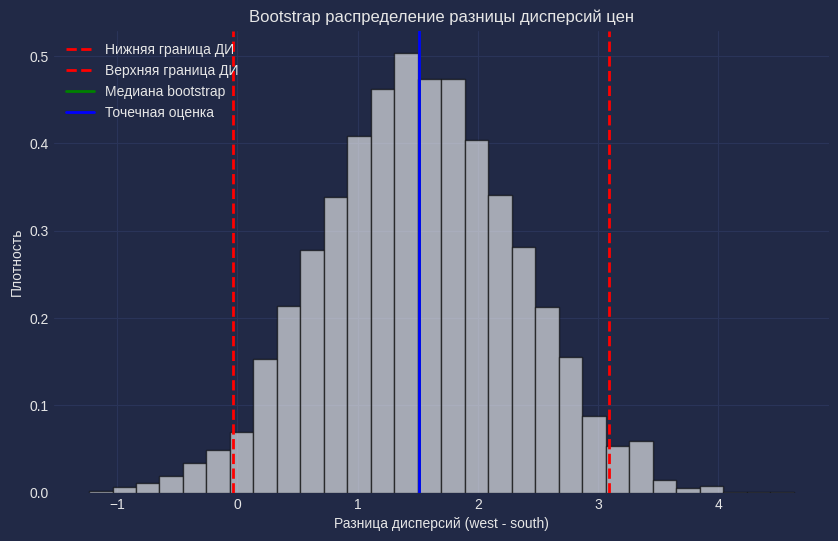

In [ ]:
with plt.style.context('cyberpunk'):
  plt.figure(figsize=(10, 6))
  plt.hist(boot_diffs, bins=30, density=True, alpha=0.6, color='white', edgecolor='black')
  plt.title('Bootstrap распределение разницы дисперсий цен')
  plt.xlabel('Разница дисперсий (west - south)')
  plt.ylabel('Плотность')

  plt.axvline(lower_ci, color='red', linestyle='--', linewidth=2, label='Нижняя граница ДИ')
  plt.axvline(upper_ci, color='red', linestyle='--', linewidth=2, label='Верхняя граница ДИ')
  median_boot = np.median(boot_diffs)
  plt.axvline(median_boot, color='green', linestyle='-', linewidth=2, label='Медиана bootstrap')
  plt.axvline(diff_variances, color='blue', linestyle='-', linewidth=2, label='Точечная оценка')

  plt.legend(facecolor='white', loc='upper left')
  plt.show()

По результатам графика нет достаточно сильных оснований утверждать о статистически значимом превосходстве дисперсии цен на Западе над Востоком (медиана бутстреп-распределения и точечная оценка дисперсии строго положительны и равны примерно 1.5, ноль едва-едва попал в ДИ), однако тест Левене утверждает, что статистически значимых различий в дисперсиях цен между группами west и south обнаружено не было.

#### 1.2.3 Критерий хи-квадрат

Сформулируем гипотезу: распределение авто с разным типом топлива одинаково по разным регионам. Предварительно удалим данные о топливе CNG и LPG ввиду их редкой встречаемости в датасете.

In [ ]:
contingency_table = pd.crosstab(data_filtered["Region"], data_filtered[
    (data_filtered["Fuel_Type"] == "Diesel") | (data_filtered["Fuel_Type"] == "Petrol")]["Fuel_Type"])
print("Таблица сопряжённости [Region x Fuel_Type]:")
print(contingency_table)

chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Статистика chi-square: {chi2:.4f}")
print(f"p-value: {p_value:.4f}")

Таблица сопряжённости [Region x Fuel_Type]:
Fuel_Type   Diesel  Petrol
Region                    
north-east     652     637
south         1054    1085
west           530     789
Статистика chi-square: 35.6699
p-value: 0.0000


Поскольку значение p-value < 0.05, то мы отвергаем нулевую гипотезу и считаем, что между признаками Location и Fuel_Type есть связь.

### 1.3 Продуктовые гипотезы

Проанализируем несколько выводов, полученных после тестирования гипотез.

#### 1.3.1 Гипотеза о медианных ценах автомобилей с разным типом топлива (бензин vs. дизель)

Тест Манна-Уитни показал, что поддержанные автомобили на бензине стоят существенно меньше, чем дизельные.

Продуктовая гипотеза: возможно, у автомобилей на бензине меньше уровня оснащения и ниже качество материалов, что вызывает бОльший износ, что, в свою очередь, отражается в цене.

Для подтверждения или опроверждения выдвинутой продуктовой гипотезы необходимо провести маркетинговое исследование: например, провести опросы среди покупателей авто у производителей, чтобы понять, воспринимают ли они автомобили на бензине как менее качественные, и какие аспекты можно улучшить (дизайн, технологии, гарантийное обслуживание). Стоит также опросить водителей, которые несколько лет ездят на авто одной ценовой категории, но на разном топливе: может быть, износ машин на безине по ряду причин выше, чем износ машин на дизеле.

Можно провести А/B-тестирование цен и комплектаций: например, производитель безниновых авто может запустить серию моделей на бензине с улучшенным оснащением, после этого аналитики компании могут протестировать, как изменится восприятие ценности и итоговая цена после нескольких лет использования.

#### 1.3.2 Гипотеза о мощности автомобилей с разным типом трансмиссии (ручная vs. автоматическая)

Тест Манна-Уитни показал, что автомобили с автоматической трансмиссией имеют статистически более высокую мощность, что может ассоциироваться с более высокой ценой. Если автомобили с ручной трансмиссией отстают, это может влиять на их стоимость (например, по причине быстрого износа).


Продуктовая гипотеза: в сегменте поддержанных авто автомобили с ручной коробкой передач недостаточно модернизированы или недооцениваются из-за предвзятых представлений покупателей.

Аналогично пункту 1.3.1 можно провести опросы водителей и выяснить, какие характеристики автомобилей с ручной коробкой особенно негативно влияют на оценку покупателями (например, технологическая устаревшесть, воспринимаемая неудобность).


Производители авто с ручной трансмиссией могут провести ряд улучшений своего модельного ряда, например, предложить специальные сервисные программы или обновлённые комплектации для автомобилей с ручной трансмиссией, чтобы протестировать, может ли это повысить их рыночную стоимость и стоимость после нескольких лет использования с целью продажи на рынке поддержанных авто.

#### 1.3.3 Гипотеза о распределении авто с разным типом по регионам

Критерий хи-квадрат показал следующее: между локациями и типами топлива выявлена связь.

Продуктовая гипотеза: региональные предпочтения и условия эксплуатации влияют на выбор топлива, что может отражаться на маркетинговой стратегии и доступности определённых моделей в конкретных регионах. Например, в некоторых городах дизельные автомобили могут ассоциироваться с более высокой проходимостью или долговечностью, а в других – наоборот, с негативными экологическими аспектами.

В качестве экспериментов можно протестировать локальные варианты продукта, например, попробовать адаптировать комплектации или сервисное обслуживание под региональные потребности, затем оценить изменения в продажах и удовлетворённости клиентов.

### 2. Блок "Регрессионный анализ"

1. Оценить модель линейной регрессии методом МНК, подготовить репорт модели и проинтерпретировать оценки коэффициентов.
2. Провести тесты на гетероскедастичность, мультиколлинеарность (как визуальные, так и численные), дать комментарии по произведенным тестам. В случае нарушения предпосылок Гаусса-Маркова – принять соответствующие корректирующие модель действия, после чего повторить пункт 1.
3. В ходе анализа протестируйте как минимум 2 спецификации моделей. Финальная спецификация модели может включать не все факторы и не все наблюдения из исходной выборки. Продемонстрируйте на примере финальной и одной из промежуточных моделей, по каким критериям и метрикам был произведен выбор в пользу финальной спецификации. Дайте трактовку значениям этих критериев и метрик.

### 2.1 Первая попытка построения модели линейной регрессии

Для начала проведем преобразования категориальных фичей с помощью LabelEncoder.

In [ ]:
categorical_features = ['Fuel_Type', 'Transmission', 'Owner_Type', 'Region', 'Year']
for col in categorical_features:
    le = LabelEncoder()
    data_filtered[col] = le.fit_transform(data_filtered[col])

In [ ]:
X = data_filtered.drop(columns=['Price', 'Name', 'Location']) # Name - аналог идентификатора, не нужен; вместо Location обучаемся на регрессоре Region
y = data_filtered['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

ols_model = sm.OLS(y_train, X_train_sm).fit()
y_pred = ols_model.predict(X_test_sm)
ols_summary = ols_model.summary()
print(ols_summary)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     1135.
Date:                Wed, 19 Mar 2025   Prob (F-statistic):               0.00
Time:                        07:05:21   Log-Likelihood:                -7745.9
No. Observations:                3812   AIC:                         1.551e+04
Df Residuals:                    3802   BIC:                         1.557e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -3.7923      0.55

Все предикторы являются значимыми.

### 2.2 Проведение тестов для регрессии

#### 2.2.1 Исследуем мультиколлинеарность данных

Для начала исследуем мультиколлинеарность визуально: построим тепловую карту корреляций между всеми признаками и таргетом `Price`.

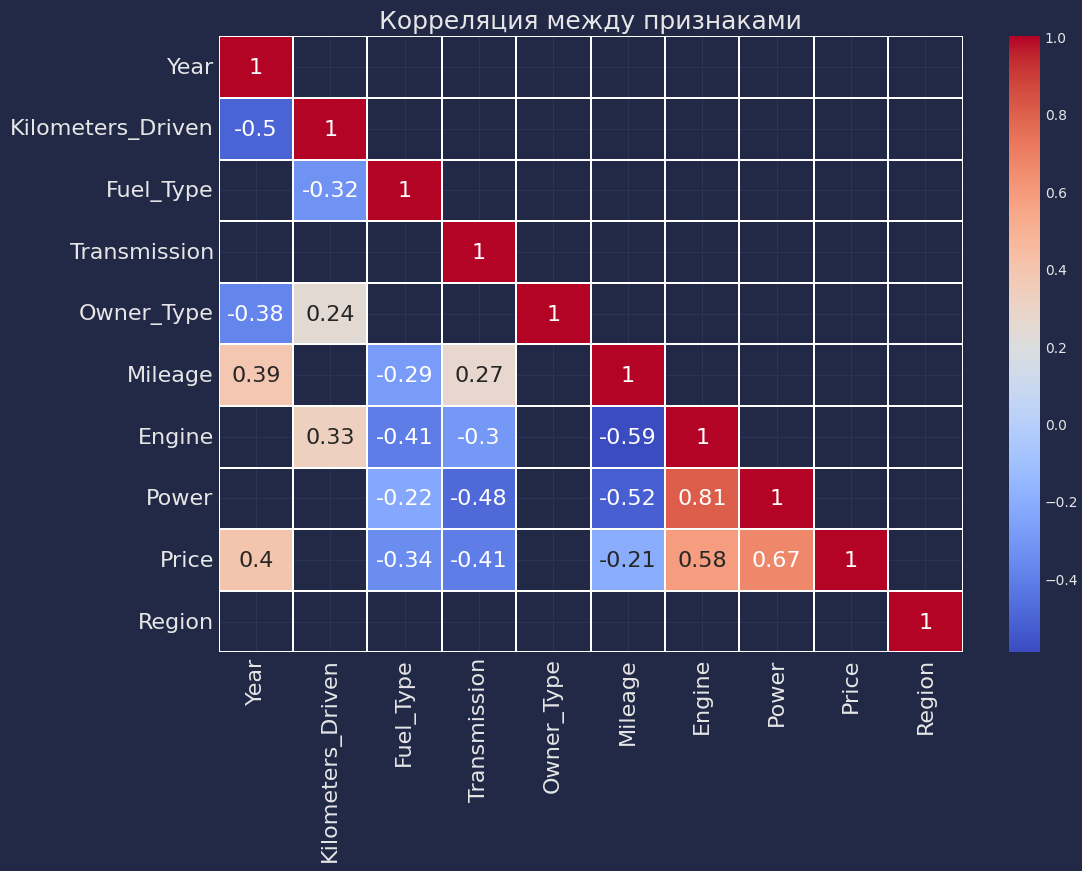

In [ ]:
with plt.style.context('cyberpunk'):
  corr_matrix = data_filtered.drop(['Name', 'Location'], axis=1).corr()
  plt.figure(figsize=(12, 8))
  mask_upper = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
  mask = np.logical_or(mask_upper, abs(corr_matrix) <= 0.20)
  sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', linewidths=0.1, annot_kws={"fontsize":16})
  plt.title('Корреляция между признаками', fontsize=18)
  plt.yticks(rotation=0, fontsize=16)
  plt.xticks(rotation=90, fontsize=16)

Чисто визуально регрессор `Engine` имеет высокую корреляцию с признаками `Power` (0.81, что весьма много!), `Mileage` (-0.59), `Fuel_Type` (-0.41). Исследуем фактор инфляции дисперсии наших признаков.  

In [ ]:
def calculate_vif(df, features):
    X = df[features].copy()
    X = sm.add_constant(X)
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

vif_result = calculate_vif(data_filtered, X.columns)
vif_result

,Feature,VIF
0,const,338.694088
1,Year,1.742831
2,Kilometers_Driven,1.666046
3,Fuel_Type,2.778861
4,Transmission,1.379765
5,Owner_Type,1.182009
6,Mileage,3.591257
7,Engine,6.232394
8,Power,3.636566
9,Region,1.022612


Видим, что VIF подозрительного предиктора `Engine` больше 5, многие специалисты считают, что это пороговое значение говорит о подозрении в наличии мультиколлинеарности данных, при следующем построении модели уберем этот признак.

#### 2.2.2 Нормальность распределения ошибки

Построим гистограмму распределения остатков модели для визуального анализа нормальности распределения, а затем применим несколько статистических тестов.

<Figure size 1200x800 with 0 Axes>

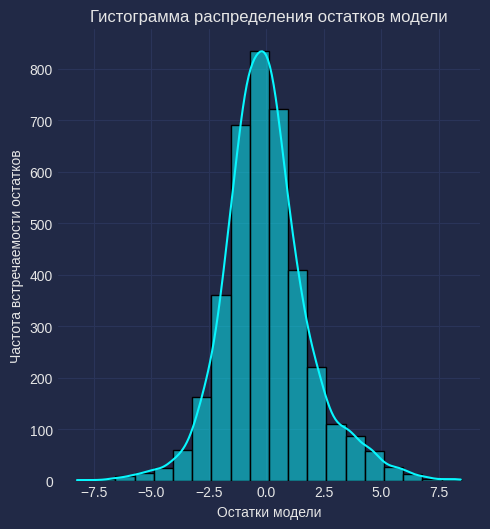

In [ ]:
with plt.style.context('cyberpunk'):
  plt.figure(figsize=(12, 8))
  sns.displot(ols_model.resid, bins=20, kde=True);
  plt.xlabel('Остатки модели')
  plt.ylabel('Частота встречаемости остатков')
  plt.title('Гистограмма распределения остатков модели')
  plt.show()

In [ ]:
residuals = ols_model.resid
shapiro_stat, shapiro_p = shapiro(residuals)
ks_stat, ks_p = kstest(residuals, 'norm', args=(np.mean(residuals), np.std(residuals, ddof=1)))
chi_stat, chi_p = normaltest(residuals)
jb_stat, jb_p = jarque_bera(residuals)
skew_stat, skew_p = skewtest(residuals)
kurt_stat, kurt_p = kurtosistest(residuals)

test_results = pd.DataFrame({
    "Test": ["Shapiro-Wilk", "Kolmogorov-Smirnov", "Chi-squared", "Jarque-Bera", "Skewness test", "Kurtosis test"],
    "Statistic": [shapiro_stat, ks_stat, chi_stat, jb_stat, skew_stat, kurt_stat],
    "p-value": [shapiro_p, ks_p, chi_p, jb_p, skew_p, kurt_p]
})

In [ ]:
test_results

,Test,Statistic,p-value
0,Shapiro-Wilk,0.973444,4.710087e-26
1,Kolmogorov-Smirnov,0.062817,1.610265e-13
2,Chi-squared,265.045297,2.793477e-58
3,Jarque-Bera,549.447381,4.886716e-120
4,Skewness test,11.197747,4.182348e-29
5,Kurtosis test,11.817604,3.165862e-32


Все статистические тесты отвергают гипотезу о нормальности остатков, соответственно, нарушается предпосылка 6.

#### 2.2.3 Исследуем гетероскедастичность данных

Для начала построим scatterplot распределения остатков по предсказанным значениям.

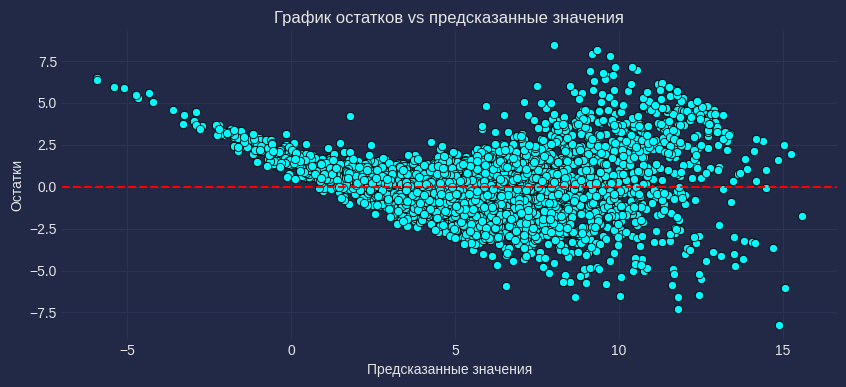

In [ ]:
with plt.style.context('cyberpunk'):
  plt.figure(figsize=(10, 4))
  plt.scatter(ols_model.fittedvalues, ols_model.resid, edgecolor="black", linewidth=0.6)
  plt.axhline(y=0, color='red', linestyle='--')
  plt.xlabel("Предсказанные значения")
  plt.ylabel("Остатки")
  plt.title("График остатков vs предсказанные значения")
  plt.show()

По графику видно, что слева разброс остатков довольно узкий; по мере увеличения предсказанных значений разброс становится шире. Это может указывать на неравномерную дисперсию остатков. Модель сработала не очень хорошо: довольно много отрицательных предсказаний, чего не может быть (таргет строго положительный).

Построим scatterplot распределения остатков по численным регрессорам (Kilometers_Driven, Mileage, Engine, Power) для визуального анализа гетероскедастичности.

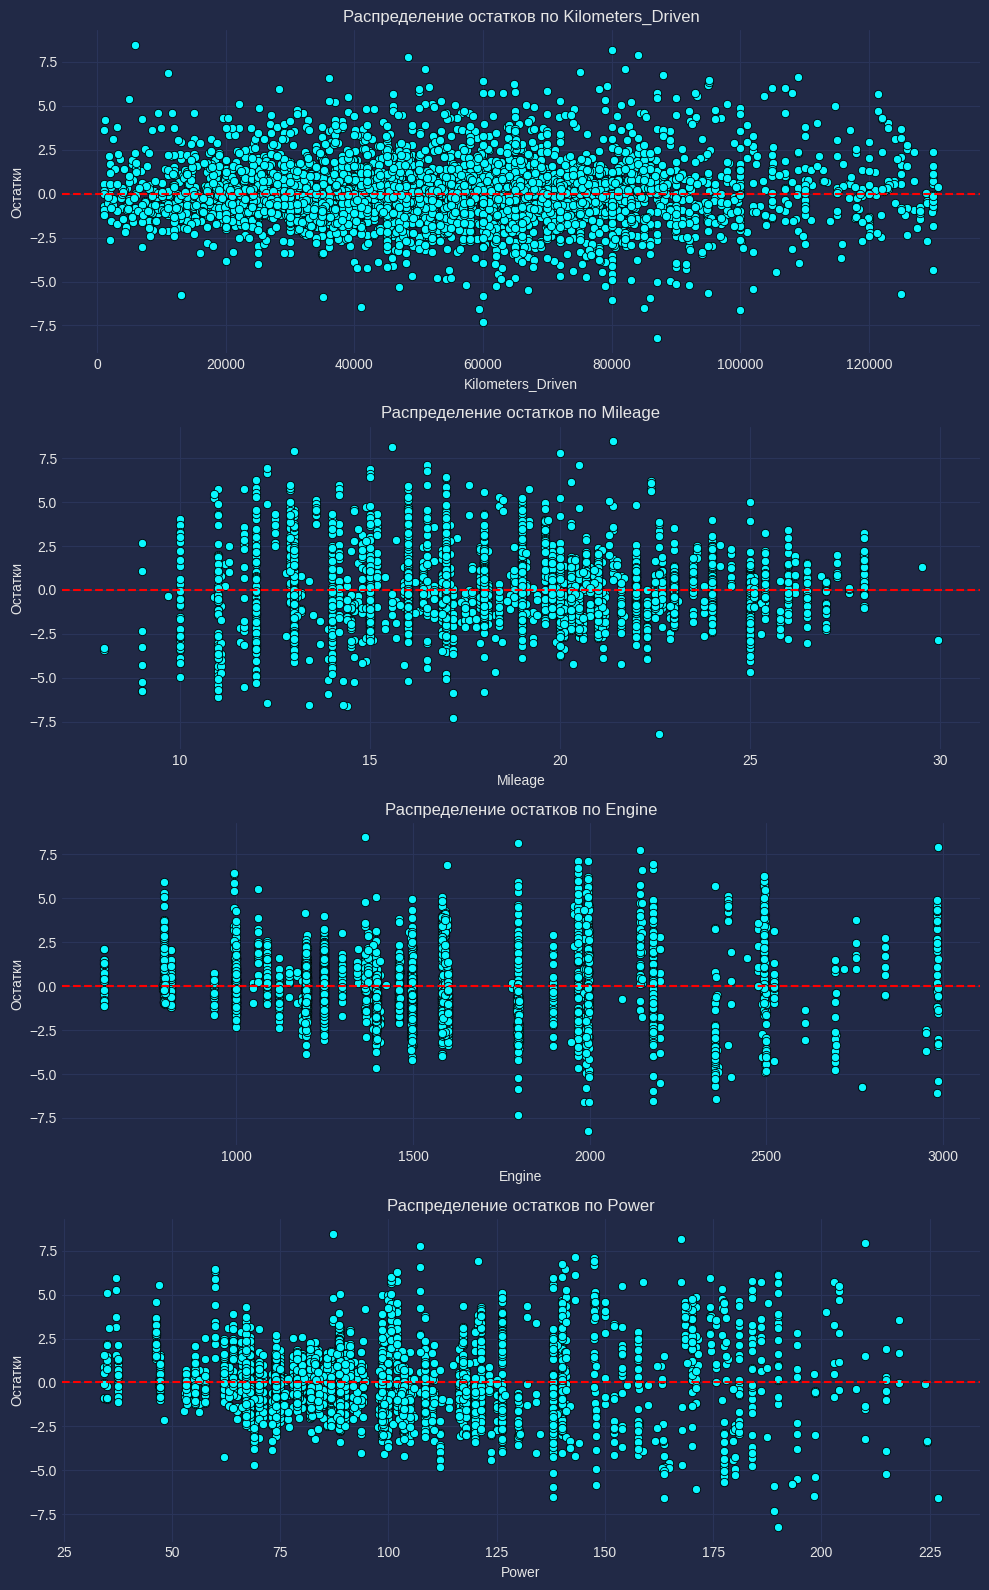

In [ ]:
numerical = ['Kilometers_Driven', 'Mileage', 'Engine', 'Power']
num_factors = len(numerical)
with plt.style.context('cyberpunk'):
  fig, axes = plt.subplots(nrows=num_factors, figsize=(10, 4 * num_factors))

  for i, factor in enumerate(numerical):
      ax = axes[i]
      sns.scatterplot(x=data_filtered[factor], y=ols_model.resid, ax=ax,
                        edgecolor="black", linewidth=0.6)
      ax.axhline(y=0, color='red', linestyle='--')
      ax.set_title(f'Распределение остатков по {factor}')
      ax.set_xlabel(factor)
      ax.set_ylabel('Остатки')

  plt.tight_layout()
  plt.show()

Во всех четырёх случаях не прослеживается явной гетероскедастичности (нет эффекта разброса остатков: например, резкого роста или падения с фактором). Остатки выглядят примерно одинаково рассеянными по вертикали во всём диапазоне каждой переменной.

Проверим гипотезу о гомоскедастичности остатков, используя тест Вайта.

In [ ]:
white_test = het_white(ols_model.resid, X_train_sm)
print(f"White Test: Chi-sq={white_test[0]:.4f}, p-value={white_test[1]:.4f}")

White Test: Chi-sq=1186.6708, p-value=0.0000


Гипотеза о гомоскедастичности остатков отклоняется ввиду p-value < 0.05. Применим тест Голдфелда — Квандта для каждого конкретного фактора.

In [ ]:
results = []
for col in ['Kilometers_Driven', 'Mileage', 'Engine', 'Power']:
    idx_val = np.where(np.array(ols_model.model.exog_names) == col)[0][0]
    gq_stat, gq_p, _ = het_goldfeldquandt(ols_model.resid, ols_model.model.exog, idx=idx_val)
    results.append({"Фактор": col, "Статистика теста GQ": gq_stat, "p-value": gq_p})

results_df = pd.DataFrame(results)
results_df

,Фактор,Статистика теста GQ,p-value
0,Kilometers_Driven,1.506586,3.031487e-19
1,Mileage,0.518069,1.000000e+00
2,Engine,3.983306,2.984886e-185
3,Power,4.045519,4.322692e-189


Тест Голдфелда — Квандта выдал p-value < 0.05 для факторов `Kilometers_Driven`, `Engine`, `Power`, поэтому для них отклоняется гипотеза, есть гетероскедастичность; по фактору `Mileage` дисперсия ошибок постоянная.

Для борьбы с гетероскедастичностью попробуем логарифмировать признаки  `Kilometers_Driven`, `Power`, а также сам таргет `Price`. `Engine` уберем из списка признаков по причине мультиколлинеарности.

### 2.3 Строим модель линейной регрессии с учетом замечаний

Итак, пробуем во второй раз построить модель линейной регрессии. Для борьбы с мультиколлинеарностью отбрасываем предиктор `Engine`, для борьбы с гетероскедастичностью используем робастные оценки дисперсии (в OLS тип `HC3`) и логарифмируем признаки `Kilometers_Driven`, `Power`, таргет `Price`.

In [ ]:
X = data_filtered.drop(columns=['Price', 'Name', 'Engine', 'Location'])
y = np.log(data_filtered['Price'])

for col in ['Kilometers_Driven', 'Power']:
  X[col] = np.log(X[col])

X_train, X_test, y_train, y_test_final = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

ols_model_final = sm.OLS(y_train, X_train_sm).fit(cov_type='HC3')
y_pred_final = ols_model_final.predict(X_test_sm)

print(ols_model_final.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     1622.
Date:                Wed, 19 Mar 2025   Prob (F-statistic):               0.00
Time:                        07:48:27   Log-Likelihood:                -370.86
No. Observations:                3812   AIC:                             759.7
Df Residuals:                    3803   BIC:                             815.9
Df Model:                           8                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -3.5150      0.17

In [ ]:
ols_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
ols_mae  = mean_absolute_error(y_test, y_pred)

ols_final_rmse = np.sqrt(mean_squared_error(y_test_final, y_pred_final))
ols_final_mae  = mean_absolute_error(y_test_final, y_pred_final)

print("OLS RMSE:", ols_rmse, "OLS MAE:", ols_mae)
print("OLS Final RMSE:", ols_final_rmse, "OLS Final MAE:", ols_final_mae)

OLS RMSE: 1.918377867744877 OLS MAE: 1.410748400066344
OLS Final RMSE: 0.2683363349110799 OLS Final MAE: 0.20980161262938876


Новая модель в прикладном смысле имеет гораздо больше пользы. Во-первых, метрики улучшилось: $R^2$ вырос с 0.729 до 0.812, AIC упал почти в два раза до значения 759.7, показатели RMSE и MAE упали в 7 раз! Во-вторых, доверительные интвервалы для предикторов стали гораздо уже, то есть оценки параметров стали более точными.

К сожалению, в теоретических аспектах модель не сильно улучшилась... Тест Уайта вновь показывает, что в данных присутствует гетероскедастичность, а тест  Голдфелда-Квандта показывает те же результаты: в модели существует гетероскедастичность по признакам `Kilometers_Driven` и `Power`.

In [ ]:
white_test = het_white(ols_model_final.resid, X_train_sm)
print(f"White Test: Chi-sq={white_test[0]}, p-value={white_test[1]}")

White Test: Chi-sq=466.6381216532871, p-value=1.6176874032684976e-72


In [ ]:
results = []
for col in ['Kilometers_Driven', 'Mileage', 'Power']:
    idx_val = np.where(np.array(ols_model_final.model.exog_names) == col)[0][0]
    gq_stat, gq_p, _ = het_goldfeldquandt(ols_model_final.resid, ols_model_final.model.exog, idx=idx_val)
    results.append({"Фактор": col, "Статистика теста GQ": gq_stat, "p-value": gq_p})

results_df = pd.DataFrame(results)
results_df

,Фактор,Статистика теста GQ,p-value
0,Kilometers_Driven,1.623679,4.185750e-26
1,Mileage,0.677431,1.000000e+00
2,Power,1.383675,8.590182e-13


Построим графики остатков с предсказанными значениями.

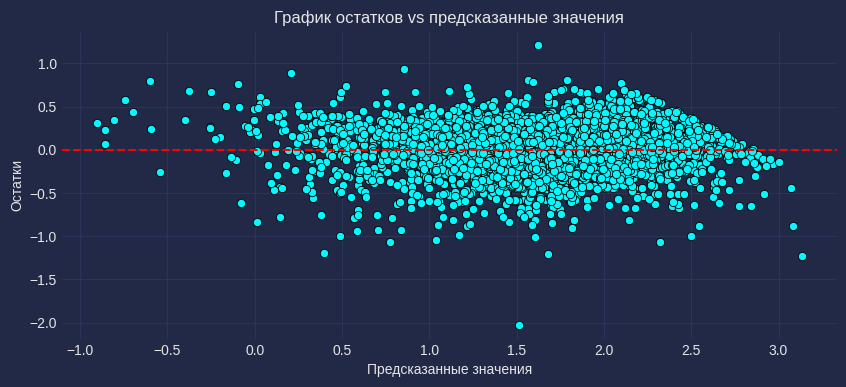

In [ ]:
with plt.style.context('cyberpunk'):
  plt.figure(figsize=(10, 4))
  plt.scatter(ols_model_final.fittedvalues, ols_model_final.resid, edgecolor="black", linewidth=0.6)
  plt.axhline(y=0, color='red', linestyle='--')
  plt.xlabel("Предсказанные значения")
  plt.ylabel("Остатки")
  plt.title("График остатков vs предсказанные значения")
  plt.show()

Вот тут картина обстоит гораздо лучше: отрицательных значений стало гораздо меньше (рассмотрение таргета как логарифм от исходных данных дало о себе знать), но, к сожалению, на крайних значениях слева и справа дисперсия остатков гораздо меньше, чем в середине графика. Однако, если сравнивать с первой моделью, этот график гораздо лучше.

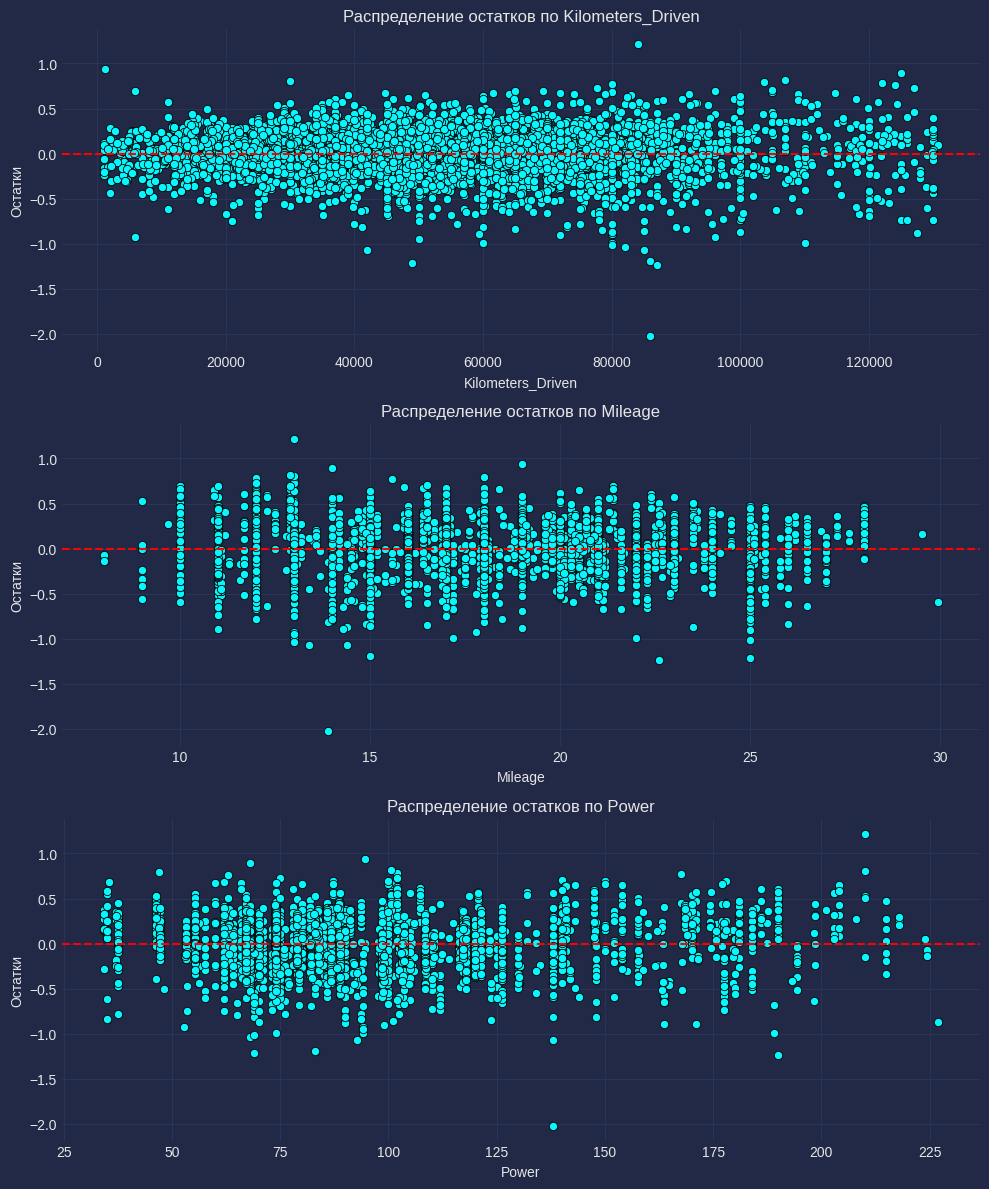

In [ ]:
numerical = ['Kilometers_Driven', 'Mileage', 'Power']
num_factors = len(numerical)
with plt.style.context('cyberpunk'):
  fig, axes = plt.subplots(nrows=num_factors, figsize=(10, 4 * num_factors))

  for i, factor in enumerate(numerical):
      ax = axes[i]
      sns.scatterplot(x=data_filtered[factor], y=ols_model_final.resid, ax=ax,
                        edgecolor="black", linewidth=0.6)
      ax.axhline(y=0, color='red', linestyle='--')
      ax.set_title(f'Распределение остатков по {factor}')
      ax.set_xlabel(factor)
      ax.set_ylabel('Остатки')

  plt.tight_layout()
  plt.show()

Графики остатков по оставшимся численным признакам, в целом, повторяют картину прошлой модели, однако дисперсия остатков стала чуть ниже.

Построим график остатков модели и исследуем их на нормальность.

<Figure size 1200x800 with 0 Axes>

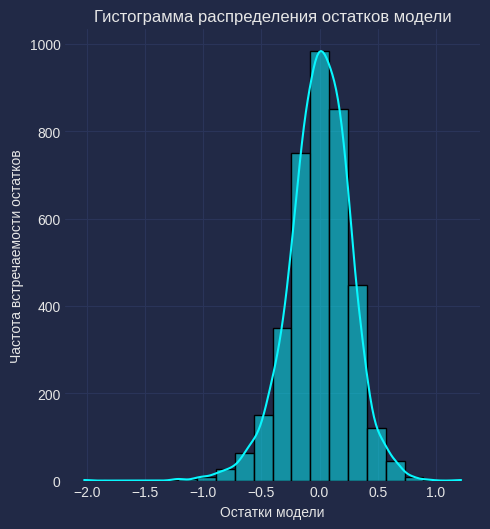

In [ ]:
with plt.style.context('cyberpunk'):
  plt.figure(figsize=(12, 8))
  sns.displot(ols_model_final.resid, bins=20, kde=True);
  plt.xlabel('Остатки модели')
  plt.ylabel('Частота встречаемости остатков')
  plt.title('Гистограмма распределения остатков модели')
  plt.show()

In [ ]:
residuals = ols_model_final.resid
shapiro_stat, shapiro_p = shapiro(residuals)
ks_stat, ks_p = kstest(residuals, 'norm', args=(np.mean(residuals), np.std(residuals, ddof=1)))
chi_stat, chi_p = normaltest(residuals)
jb_stat, jb_p = jarque_bera(residuals)
skew_stat, skew_p = skewtest(residuals)
kurt_stat, kurt_p = kurtosistest(residuals)

test_results = pd.DataFrame({
    "Test": ["Shapiro-Wilk", "Kolmogorov-Smirnov", "Chi-squared", "Jarque-Bera", "Skewness test", "Kurtosis test"],
    "Statistic": [shapiro_stat, ks_stat, chi_stat, jb_stat, skew_stat, kurt_stat],
    "p-value": [shapiro_p, ks_p, chi_p, jb_p, skew_p, kurt_p]
})

In [ ]:
test_results

,Test,Statistic,p-value
0,Shapiro-Wilk,0.983897,1.954635e-20
1,Kolmogorov-Smirnov,0.033556,3.650627e-04
2,Chi-squared,289.010057,1.746882e-63
3,Jarque-Bera,671.557306,1.489992e-146
4,Skewness test,-11.247893,2.371917e-29
5,Kurtosis test,12.747352,3.225171e-37


Все тесты показали, что остатки не являются нормальными.

In [ ]:
vif_result = calculate_vif(data_filtered, X.columns)
vif_result

,Feature,VIF
0,const,201.730995
1,Year,1.731109
2,Kilometers_Driven,1.655815
3,Fuel_Type,1.676982
4,Transmission,1.367890
5,Owner_Type,1.180951
6,Mileage,2.118778
7,Power,2.189768
8,Region,1.022534


Удаление предиктора `Engine` действительно помогло справиться с мультиколлинеарностью данных.

Таким образом, для прогнозирования цены я бы остановился на второй модели: ее метрики гораздо лучше метрик первой модели, мы избавились от мультиколлинерности данных.

## Заключение

В результате проведённого анализа было получено несколько важных выводов:

1. Статистические тесты показали, что поддержанные автомобили на дизельном топливе имеют существенно более высокие цены по сравнению с бензиновыми моделями; модели на других видах топлива практически отсутствуют на рынке поддержанных авто. Аналогично, модели с автоматической трансмиссией демонстрируют более высокую мощность, что может отражаться на их ценовом сегменте.

2. Первоначальная OLS-модель имела $R^2 = 0.729$, однако после устранения мультиколлинеарности (исключения переменной Engine) и применения логарифмических преобразований для `Price`, `Kilometers_Driven` и `Power` и использования робастных оценок качество модели улучшилось до $R^2 = 0.812$, AIC упал почти в два раза по сравнению с AIC первой модели, показатели RMSE и MAE упали в 7 раз. Это свидетельствует о лучшем объяснении целевой переменной, практическая ценность финальной модели линейной регрессии гораздо выше.

3. К сожалению, теоретические аспекты финальной модели линейной регрессии радуют гораздо меньше: тесты на нормальность не подтвердили нормальное распределение остатков, избавиться целиком от гетероскедастичности не удалось, однако улучшение метрик модели позволяют считать модель более надёжной для прогнозирования.


4. Был выдивинут ряд продуктовых гипотез для улучшения показателей отстающих групп, предложены эксперименты.